# **African Wildlife**

# About Dataset

This dataset was created to train devices for real-time animal detection in South African nature reserves. It includes images and labels for four animals: buffalo, elephant, rhino, and zebra, collected through Google searches and manually labeled in the YOLO format. Each animal class has at least 376 images, and the images may contain multiple animals of the same or different classes. The labels provide the necessary information for object detection tasks.

# Data loading from kaggle and creating the necessary directories

I am downloading datasets from kaggle and extracting them into designated directories within my working environment. The script creates the necessary directories, downloads the datasets in chunks to handle large files efficiently, and uncompresses them, whether they are in zip or tar format. This setup ensures that all required data is readily available in the /kaggle/input directory for my analysis, with symlinks created for easy access.

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'african-wildlife:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F674157%2F1185810%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240706%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240706T132054Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D7b07ac549f9d5678992164446861447af674338a175c7652aa7ed1ccc41c7f9268917cb82ca95cb3845bf71b0a6492f42072ba5be71bdb44d6b6a476f34834cbe10278ef08e40197fb3d601f9a9943b908eb6858b0387fba7bcd2e1d7f48bed5f4db3bdf8bf7a13aca4a43c62c0cf8fd954aa320309fa125fb9b53ce020a069fd03ca2154ded701e40a246a098481fb2e52d7ec500f26753ca5384890f54386a99f83b407e8f17074d8f8beade438b47cf59a947b91710c147fc33e9afb270c6bf32e965f3b3d812f5b3b5e043ccddb4cb6c4a024624e7007d90d959945085b7b52efd88952cbbd7bea991a43b9ae059775cfb986fb51b0591d964f118151f6d'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 469442673 bytes downloaded
Downloaded and uncompressed: african-wildlife
Data source import complete.


In [ ]:
# Install required libraries
!pip install ultralytics
!pip install ray
!pip install wandb

### This is a multi-class object detection problem. Let's solve it using state-of-the-art YOLOv8

In [ ]:
# Importing necessary libraries
import os
import shutil
import cv2
import random
import matplotlib.pyplot as plt

import numpy as np
import copy
import wandb

In [ ]:
from ultralytics import YOLO

In [ ]:
import wandb
os.environ["WANDB_API_KEY"] = "4b60849b517b0f33d5984c0acb3cdb134c555ce5"
wandb.login()

wandb: Currently logged in as: anandhukrishna091 (action_learning). Use `wandb login --relogin` to force relogin


True

In [ ]:
# Defining data path and listing its contents
ip_datapath='/kaggle/input/african-wildlife'
os.listdir(ip_datapath)

['elephant', 'zebra', 'rhino', 'buffalo']

In [ ]:
# Defining standard image size for YOLO v8
image_size=640

# Creating working directories

In [ ]:
# Creating paths for separate images and labels
curr_path=os.getcwd()
imgtrainpath = os.path.join(curr_path,'images','train')
imgvalpath=os.path.join(curr_path,'images','validation')
imgtestpath=os.path.join(curr_path,'images','test')

labeltrainpath=os.path.join(curr_path,'labels','train')
labelvalpath=os.path.join(curr_path,'labels','validation')
labeltestpath=os.path.join(curr_path,'labels','test')

# Creating directories for all paths defined
os.makedirs(imgtrainpath)
os.makedirs(imgvalpath)
os.makedirs(imgtestpath)
os.makedirs(labeltrainpath)
os.makedirs(labelvalpath)
os.makedirs(labeltestpath)

 Let's take images and labels of all the classes to working space and also rename them according to their class which can be buffalo, elephant, rhino or zebra.

In [ ]:
for dirname in os.listdir(ip_datapath):
    dirpath=os.path.join(ip_datapath, dirname)
    for file in os.listdir(dirpath):
        filepath=os.path.join(dirpath, file)
        newname=dirname+'_'+file
        if file.endswith((".txt")): # if label file, take it to label train path
            shutil.copy(filepath, labeltrainpath)
            path=os.path.join(labeltrainpath, file)
            newpath=os.path.join(labeltrainpath, newname)
        elif file.endswith((".jpg", ".JPG")): # if image file, resize and take it to image train path
            img_resized=cv2.resize(cv2.imread(filepath), (image_size, image_size))
            path=os.path.join(imgtrainpath, file)
            cv2.imwrite(path, img_resized)
            newpath=os.path.join(imgtrainpath, newname)
        os.rename(path, newpath) # Rename the file (label or image)


In [ ]:
# Checking the number of image and label files for all classes
len(os.listdir(imgtrainpath)), len(os.listdir(labeltrainpath))

(1504, 1504)

# Extracting and visualising test images

Let's create a difficult test set to see how good our model can be.

1. Of all the images, we will include those images in test set which have objects of different classes. So all test images will have at least 2 objects of different classes. For example, a buffalo and a zebra in a single image is qualified to be part of the test data set. There can be multiple objects too. So 2 elephants and 1 buffalo in a single image is also perfectly valid.

2. For the training and validation set, we will have images of only one object class. For example, any image in training and validation set can have one type of animal only, say rhino. Although there can be multiple rhinos in the same image.



In [ ]:
# function to check if all elements in the list are actually the same
def are_all_elements_same(lst):
    if not lst:
        return True  # An empty list is considered to have all elements the same.

    first_element = lst[0]
    for element in lst[1:]:
        if element != first_element:
            return False

    return True

Let's extract all the images with different types of animals present in the same image

In [ ]:
for file in os.listdir(labeltrainpath):
    classes_list=[]
    with open(os.path.join(labeltrainpath, file), "r") as f:
        for line in f:
            class_id,_,_,_,_=line.strip().split(" ")
            classes_list.append(class_id) # creating list of all unique animal types in given image

    # Checking if different types of animals are present in image
    if not are_all_elements_same(classes_list):
        filepath=os.path.join(labeltrainpath, file)
        newpath=os.path.join(labeltestpath, file)
        shutil.move(filepath, newpath) # moving label file to test path
        basename=os.path.splitext(file)[0]
        print(basename) # printing the image name
        imgfilename=basename+'.jpg'
        oldimgfilepath=os.path.join(imgtrainpath, imgfilename)
        newimgfilepath=os.path.join(imgtestpath, imgfilename)
        shutil.move(oldimgfilepath, newimgfilepath) # moving image to test path



buffalo_273
buffalo_291
buffalo_297
buffalo_301
rhino_256
rhino_238
buffalo_300
rhino_375
elephant_290
buffalo_299
zebra_338
elephant_166
elephant_345
zebra_339
elephant_288
elephant_291
buffalo_298
zebra_073


The above printed images are all those which have more than one type of animal in it, although the name suggests that there is just one animal. Let's check few of these images

In [ ]:
plt.figure(figsize=(30,30))
for i in range(6):
    test_image=os.path.join(imgtestpath, os.listdir(imgtestpath)[i])
    ax=plt.subplot(3,2,i+1)

    # Display actual image
    plt.imshow(cv2.imread(test_image))
    plt.xticks([])
    plt.yticks([])

We can see how the above images have different types of animals in the same image

In [ ]:
# Checking the size of test dataset
len(os.listdir(imgtestpath)), len(os.listdir(labeltestpath))

(18, 18)

In [ ]:
# Checking the size of training(+validation) dataset
len(os.listdir(imgtrainpath)), len(os.listdir(labeltrainpath))

(1486, 1486)

# Separating training and validation dataset

Let's now partition the training dataset into training and validation dataset

In [ ]:
# moving 20% of data to validation

factor=0.2

for file in random.sample(os.listdir(imgtrainpath), int(len(os.listdir(imgtrainpath))*factor)):
    basename=os.path.splitext(file)[0]
    textfilename=basename+'.txt'
    labelfilepath=os.path.join(labeltrainpath, textfilename)
    labeldestpath=os.path.join(labelvalpath, textfilename)
    imgfilepath=os.path.join(imgtrainpath, file)
    imgdestpath=os.path.join(imgvalpath, file)
    shutil.move(imgfilepath, imgdestpath)
    shutil.move(labelfilepath, labeldestpath)

In [ ]:
# Checking the size of training dataset
len(os.listdir(imgtrainpath)), len(os.listdir(labeltrainpath))

(1189, 1189)

In [ ]:
# Checking the size of validation dataset
len(os.listdir(imgvalpath)), len(os.listdir(labelvalpath))

(297, 297)

# Image visualisation with bounding box

Function to obtain bounding box coordinates of the images from the label files The label files contain information about image type, image centre coordinates and image size.

In [ ]:
# function to obtain bounding box coordinates from text label files
def get_bbox_from_label(text_file_path):
    bbox_list=[]
    with open(text_file_path, "r") as file:
        for line in file:
            class_id,x_centre,y_centre,width,height=line.strip().split(" ")
            x1=(float(x_centre)+(float(width)/2))*image_size
            x0=(float(x_centre)-(float(width)/2))*image_size
            y1=(float(y_centre)+(float(height)/2))*image_size
            y0=(float(y_centre)-(float(height)/2))*image_size

            vertices=np.array([[int(x0), int(y0)], [int(x1), int(y0)],
                               [int(x1),int(y1)], [int(x0),int(y1)]])
            bbox_list.append(vertices)
    return tuple(bbox_list)

In [ ]:
# defining red color in RGB to draw bounding box
red=(255,0,0)

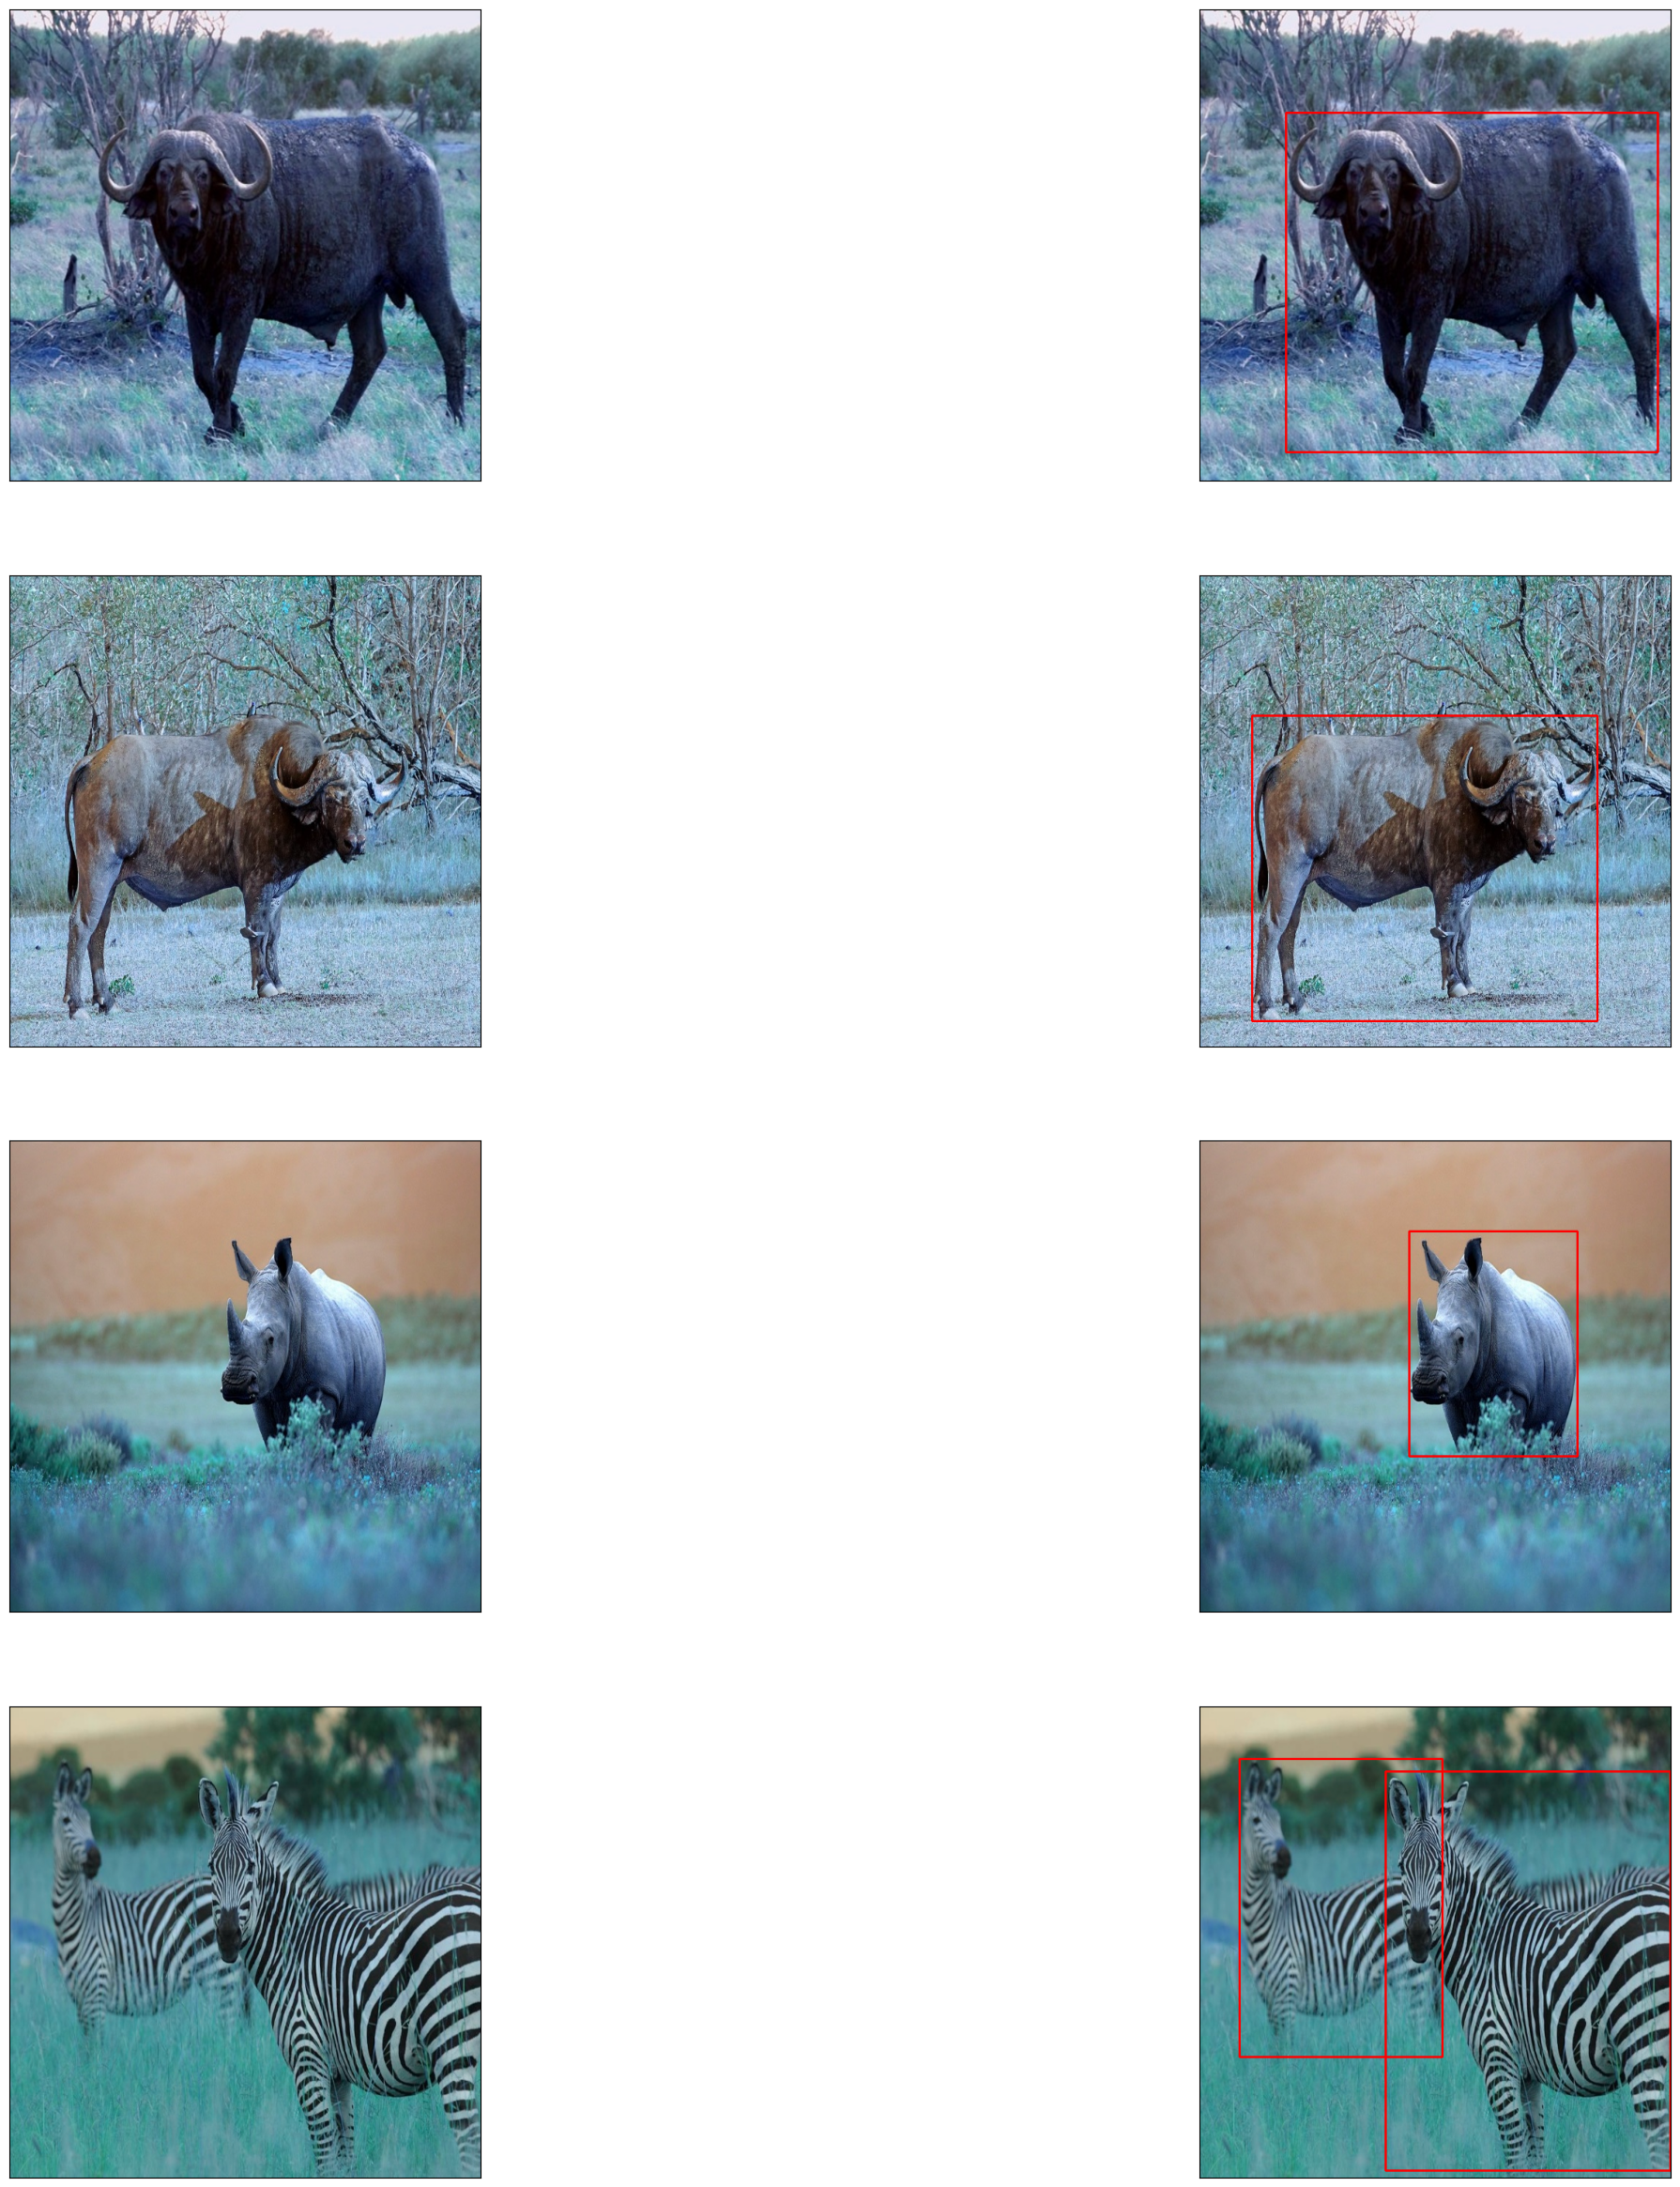

In [ ]:
# Drawing bounding box for random images in training data
plt.figure(figsize=(30,30))
for i in range(1,8,2):
    k=random.randint(0, len(os.listdir(imgtrainpath))-1)
    img_path=os.path.join(imgtrainpath, sorted(os.listdir(imgtrainpath))[k])
    label_path=os.path.join(labeltrainpath, sorted(os.listdir(labeltrainpath))[k])
    bbox=get_bbox_from_label(label_path) # extracting bounding box coordinates
    image=cv2.imread(img_path)
    image_copy=copy.deepcopy(image)
    ax=plt.subplot(4, 2, i)
    plt.imshow(image) # displaying image
    plt.xticks([])
    plt.yticks([])
    cv2.drawContours(image_copy, bbox, -1, red, 2) # drawing bounding box on copy of image
    ax=plt.subplot(4, 2, i+1)
    plt.imshow(image_copy) # displaying image with bounding box
    plt.xticks([])
    plt.yticks([])

# Creating config file

In [ ]:
# defining newline variable for config file
newline='\n'

Let's declare the contents of configuration file

In [ ]:
# Starting with a comment in config file
ln_1='# Train/val/test sets'+newline

# train, val and test path declaration
ln_2='train: ' +"'"+imgtrainpath+"'"+newline
ln_3='val: ' +"'" + imgvalpath+"'"+newline
ln_4='test: ' +"'" + imgtestpath+"'"+newline
ln_5=newline
ln_6='# Classes'+newline

# names of the classes declaration
ln_7='names:'+newline
ln_8='  0: buffalo'+newline
ln_9='  1: elephant'+newline
ln_10='  2: rhino'+newline
ln_11='  3: zebra'

config_lines=[ln_1, ln_2, ln_3, ln_4, ln_5, ln_6, ln_7, ln_8, ln_9, ln_10, ln_11]

In [ ]:
# Creating path for config file
config_path=os.path.join(curr_path, 'config.yaml')
config_path

'/content/config.yaml'

In [ ]:
# Writing config file
with open(config_path, 'w') as f:
    f.writelines(config_lines)

# Model training

A YOLO model architecture specified in yolov8m.yaml with pretrained weights from yolov8m.pt is instantiated. This model is then trained using the configuration specified in config_path for 100 epochs, aiming to improve its ability to detect objects with an Intersection over Union (IoU) threshold of 0.5 and confidence threshold of 0.01. This process involves adjusting the model's internal parameters based on the dataset provided in config_path to enhance its accuracy in identifying objects such as animals in images.

In [ ]:
# Using YOLO's pretrained model architecture and weights for training
model=YOLO('yolov8m.yaml').load('yolov8m.pt')

100%|██████████| 49.7M/49.7M [00:00<00:00, 239MB/s]


Transferred 475/475 items from pretrained weights


In [ ]:
# Training the model
results=model.train(data=config_path, epochs=100, iou=0.5, conf=0.01)

Ultralytics YOLOv8.2.50 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.yaml, data=/content/config.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=0.01, iou=0.5, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_box

100%|██████████| 755k/755k [00:00<00:00, 39.0MB/s]


Overriding model.yaml nc=80 with nc=4

                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1   1991808  ultralytics

Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...


100%|██████████| 6.25M/6.25M [00:00<00:00, 176MB/s]
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


AMP: checks passed ✅


train: Scanning /content/labels/train... 1189 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1189/1189 [00:00<00:00, 2013.98it/s]


train: New cache created: /content/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/labels/validation... 297 images, 0 backgrounds, 0 corrupt: 100%|██████████| 297/297 [00:00<00:00, 1091.53it/s]

val: New cache created: /content/labels/validation.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      7.13G     0.8936      1.682      1.366         16        640: 100%|██████████| 75/75 [00:44<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.64it/s]

                   all        297        517      0.683       0.66        0.7      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      7.11G      1.146      1.491       1.51         31        640: 100%|██████████| 75/75 [00:40<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.18it/s]

                   all        297        517       0.46      0.447      0.396      0.202



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      7.09G      1.216      1.615      1.568         23        640: 100%|██████████| 75/75 [00:41<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.58it/s]

                   all        297        517      0.432      0.361      0.353      0.144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      7.07G      1.251      1.581      1.586         18        640: 100%|██████████| 75/75 [00:39<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.07it/s]

                   all        297        517       0.54      0.462       0.49      0.277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      7.13G      1.215      1.524      1.567         19        640: 100%|██████████| 75/75 [00:40<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.13it/s]

                   all        297        517      0.687        0.6       0.64       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100         7G      1.175      1.467      1.532         13        640: 100%|██████████| 75/75 [00:40<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.50it/s]

                   all        297        517      0.655      0.615       0.64      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      7.09G      1.102      1.365      1.469         14        640: 100%|██████████| 75/75 [00:41<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.15it/s]

                   all        297        517      0.759      0.637      0.738      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      7.09G      1.087      1.319      1.458         14        640: 100%|██████████| 75/75 [00:40<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.21it/s]

                   all        297        517      0.779      0.636      0.752      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      7.11G      1.058      1.249      1.447         17        640: 100%|██████████| 75/75 [00:41<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.84it/s]

                   all        297        517      0.809      0.754      0.823      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      7.01G       1.04      1.204      1.431         26        640: 100%|██████████| 75/75 [00:41<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.08it/s]

                   all        297        517      0.772      0.677      0.755      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100       7.1G      1.026       1.17      1.418         24        640: 100%|██████████| 75/75 [00:41<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.59it/s]

                   all        297        517      0.839      0.729      0.845      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100       7.1G       1.02      1.162      1.401         21        640: 100%|██████████| 75/75 [00:40<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.02it/s]

                   all        297        517      0.783      0.726      0.781      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      7.14G     0.9698      1.096       1.37         21        640: 100%|██████████| 75/75 [00:41<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.16it/s]

                   all        297        517      0.874      0.836      0.908      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      7.04G     0.9382      1.045      1.354         18        640: 100%|██████████| 75/75 [00:41<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.63it/s]

                   all        297        517      0.887      0.777      0.881       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      7.07G     0.9185       1.05      1.333         16        640: 100%|██████████| 75/75 [00:41<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.13it/s]

                   all        297        517      0.888      0.818      0.897      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      7.11G     0.9102     0.9905      1.331         21        640: 100%|██████████| 75/75 [00:40<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.59it/s]

                   all        297        517      0.822      0.739      0.827        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      7.13G     0.9041     0.9916      1.332         20        640: 100%|██████████| 75/75 [00:40<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]

                   all        297        517      0.918      0.788      0.905      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      7.01G       0.89     0.9701      1.321         18        640: 100%|██████████| 75/75 [00:41<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.59it/s]

                   all        297        517      0.876      0.842      0.917      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      7.09G     0.8779     0.9467      1.322         12        640: 100%|██████████| 75/75 [00:40<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.20it/s]

                   all        297        517      0.905      0.797      0.915      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      7.09G     0.8711     0.9184      1.317         16        640: 100%|██████████| 75/75 [00:40<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.67it/s]

                   all        297        517      0.876      0.857      0.911      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      7.11G     0.8518     0.9086      1.299         37        640: 100%|██████████| 75/75 [00:41<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.19it/s]

                   all        297        517      0.866       0.82      0.896      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      7.01G     0.8365     0.8476      1.279         15        640: 100%|██████████| 75/75 [00:41<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.78it/s]

                   all        297        517      0.915      0.844      0.931      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      7.11G     0.8485     0.9245      1.292         18        640: 100%|██████████| 75/75 [00:41<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.04it/s]

                   all        297        517      0.884      0.816      0.903      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      7.08G     0.8241     0.8748       1.28          8        640: 100%|██████████| 75/75 [00:41<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.12it/s]

                   all        297        517      0.894       0.79      0.889      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      7.11G      0.801     0.8691      1.259         15        640: 100%|██████████| 75/75 [00:41<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.82it/s]

                   all        297        517        0.9      0.865      0.932       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      7.03G     0.8169     0.8375      1.263         13        640: 100%|██████████| 75/75 [00:40<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.13it/s]

                   all        297        517      0.889       0.87      0.928      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100       7.1G     0.8033     0.8197      1.258         14        640: 100%|██████████| 75/75 [00:40<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.47it/s]

                   all        297        517      0.876      0.865      0.916      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      7.08G      0.798     0.8111       1.26         19        640: 100%|██████████| 75/75 [00:41<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.19it/s]

                   all        297        517      0.915      0.887      0.948      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      7.11G     0.7913      0.835      1.252         21        640: 100%|██████████| 75/75 [00:41<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.69it/s]

                   all        297        517      0.891      0.882      0.937      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      6.99G     0.7864     0.7599      1.247         17        640: 100%|██████████| 75/75 [00:41<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.21it/s]

                   all        297        517      0.895      0.881      0.932       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      7.12G     0.7505     0.7442      1.225         16        640: 100%|██████████| 75/75 [00:41<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.60it/s]

                   all        297        517      0.932      0.884      0.951      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      7.08G      0.743      0.735      1.217         17        640: 100%|██████████| 75/75 [00:40<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.16it/s]

                   all        297        517      0.929      0.872      0.949      0.765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      7.12G     0.7697     0.7584       1.23         13        640: 100%|██████████| 75/75 [00:41<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.68it/s]

                   all        297        517      0.911      0.848      0.928      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100         7G     0.7436     0.7275      1.218         13        640: 100%|██████████| 75/75 [00:40<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.14it/s]

                   all        297        517      0.948      0.856      0.948      0.783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      7.11G     0.7535     0.7353      1.226         24        640: 100%|██████████| 75/75 [00:40<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.05it/s]

                   all        297        517      0.899      0.855      0.926      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      7.09G     0.7414     0.7333       1.21         18        640: 100%|██████████| 75/75 [00:41<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.98it/s]

                   all        297        517      0.932      0.859       0.93      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      7.11G     0.7401     0.7249      1.211         26        640: 100%|██████████| 75/75 [00:41<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.00it/s]

                   all        297        517      0.927      0.855      0.939      0.767



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      7.03G     0.7276       0.73      1.194         20        640: 100%|██████████| 75/75 [00:41<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.99it/s]

                   all        297        517      0.933      0.877      0.944      0.773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      7.11G     0.7258      0.703      1.192         14        640: 100%|██████████| 75/75 [00:41<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.73it/s]

                   all        297        517      0.912       0.89       0.94      0.785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      7.09G     0.7281      0.705        1.2         19        640: 100%|██████████| 75/75 [00:41<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.93it/s]

                   all        297        517      0.912      0.936      0.961      0.782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      7.15G     0.7087     0.6949      1.186         15        640: 100%|██████████| 75/75 [00:42<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  2.00it/s]

                   all        297        517      0.926      0.876      0.952      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      7.07G     0.7166     0.6788      1.193         22        640: 100%|██████████| 75/75 [00:40<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.76it/s]

                   all        297        517      0.913      0.912      0.955      0.792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      7.08G     0.7027      0.657      1.191         17        640: 100%|██████████| 75/75 [00:41<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.15it/s]

                   all        297        517       0.92      0.866       0.94       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      7.11G     0.6942     0.6679      1.178         19        640: 100%|██████████| 75/75 [00:40<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.59it/s]

                   all        297        517       0.93      0.899       0.95      0.787



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100       7.1G     0.7201     0.6744       1.19         14        640: 100%|██████████| 75/75 [00:40<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.21it/s]

                   all        297        517      0.934      0.874      0.947       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100         7G     0.7061     0.6535      1.179         18        640: 100%|██████████| 75/75 [00:41<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.65it/s]

                   all        297        517      0.928      0.908      0.957      0.785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      7.11G     0.6833     0.6356      1.181         17        640: 100%|██████████| 75/75 [00:41<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.20it/s]

                   all        297        517      0.918      0.896      0.956      0.793



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100       7.1G     0.6955     0.6504      1.187         27        640: 100%|██████████| 75/75 [00:41<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.54it/s]

                   all        297        517      0.936      0.895      0.956      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100       7.1G     0.6498     0.5947      1.143          8        640: 100%|██████████| 75/75 [00:40<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.20it/s]

                   all        297        517      0.928      0.903      0.954      0.793



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      7.08G     0.6742     0.6177      1.157         33        640: 100%|██████████| 75/75 [00:40<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.57it/s]

                   all        297        517      0.932      0.902      0.953      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      7.09G     0.6577     0.5952      1.151         17        640: 100%|██████████| 75/75 [00:42<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.15it/s]

                   all        297        517      0.917      0.883      0.946      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      7.08G     0.6666      0.596       1.16         19        640: 100%|██████████| 75/75 [00:40<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.59it/s]

                   all        297        517      0.928       0.89       0.95        0.8



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      7.11G     0.6563     0.6127      1.153         19        640: 100%|██████████| 75/75 [00:40<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.23it/s]

                   all        297        517       0.91      0.906      0.953      0.807



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      6.98G     0.6621     0.5934      1.158         18        640: 100%|██████████| 75/75 [00:40<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.85it/s]

                   all        297        517      0.921      0.908      0.964      0.812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      7.09G      0.643     0.5806      1.144         18        640: 100%|██████████| 75/75 [00:41<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.70it/s]

                   all        297        517      0.925      0.919      0.956      0.799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100       7.1G     0.6437      0.571       1.14         14        640: 100%|██████████| 75/75 [00:41<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.09it/s]

                   all        297        517      0.927      0.917      0.961      0.804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      7.11G     0.6485     0.5992      1.147         16        640: 100%|██████████| 75/75 [00:41<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.81it/s]

                   all        297        517      0.944      0.909      0.957      0.813



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100         7G      0.644     0.5803      1.144         19        640: 100%|██████████| 75/75 [00:42<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.53it/s]

                   all        297        517      0.959      0.894      0.962      0.811



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      7.11G      0.627     0.5539      1.134         12        640: 100%|██████████| 75/75 [00:40<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.00it/s]

                   all        297        517      0.944      0.908      0.962       0.82



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      7.08G     0.6213     0.5564      1.125         12        640: 100%|██████████| 75/75 [00:40<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.95it/s]

                   all        297        517      0.919      0.921       0.96      0.814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      7.11G       0.64     0.5755       1.14         20        640: 100%|██████████| 75/75 [00:40<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.94it/s]

                   all        297        517      0.927      0.915      0.956      0.814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100         7G     0.6236     0.5565       1.12         18        640: 100%|██████████| 75/75 [00:41<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.45it/s]

                   all        297        517      0.948      0.892      0.959      0.822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      7.09G     0.6191     0.5444      1.124         23        640: 100%|██████████| 75/75 [00:40<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.25it/s]

                   all        297        517      0.893      0.921      0.951      0.808



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      7.11G     0.6064     0.5505      1.133         17        640: 100%|██████████| 75/75 [00:40<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.20it/s]

                   all        297        517      0.904      0.937      0.963      0.818



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      7.12G     0.6113     0.5301      1.116         25        640: 100%|██████████| 75/75 [00:40<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.23it/s]

                   all        297        517      0.922      0.934      0.963      0.825



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100         7G     0.6132     0.5317      1.125         20        640: 100%|██████████| 75/75 [00:40<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.24it/s]

                   all        297        517      0.938      0.932      0.964      0.827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      7.09G     0.6332     0.5449      1.148         14        640: 100%|██████████| 75/75 [00:40<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]

                   all        297        517      0.931      0.911      0.962      0.818



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      7.08G     0.6154     0.5283       1.12         28        640: 100%|██████████| 75/75 [00:40<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.22it/s]

                   all        297        517      0.935      0.912      0.962      0.828



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      7.11G     0.5842     0.5069      1.097         14        640: 100%|██████████| 75/75 [00:41<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.20it/s]

                   all        297        517      0.937      0.921      0.963      0.827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      7.03G     0.5741     0.5068      1.098         30        640: 100%|██████████| 75/75 [00:41<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.53it/s]

                   all        297        517      0.936      0.926      0.962      0.828



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100       7.1G     0.5962       0.51      1.114         25        640: 100%|██████████| 75/75 [00:41<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.44it/s]

                   all        297        517      0.941      0.908      0.958      0.822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      7.14G     0.5961     0.5099      1.111         17        640: 100%|██████████| 75/75 [00:40<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.24it/s]

                   all        297        517      0.944      0.909      0.957      0.828



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100       7.1G     0.5756     0.5101      1.096         19        640: 100%|██████████| 75/75 [00:41<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.21it/s]

                   all        297        517      0.956      0.906      0.961       0.83



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100         7G     0.5662     0.4864      1.098         18        640: 100%|██████████| 75/75 [00:41<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.22it/s]

                   all        297        517      0.927      0.916      0.959      0.842



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      7.07G     0.5739      0.498      1.097         12        640: 100%|██████████| 75/75 [00:41<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.22it/s]

                   all        297        517      0.957      0.898      0.962      0.838



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      7.09G     0.5794     0.4826      1.102         16        640: 100%|██████████| 75/75 [00:40<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.20it/s]

                   all        297        517       0.95      0.891      0.958      0.835



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      7.11G     0.5683     0.4807      1.091         11        640: 100%|██████████| 75/75 [00:41<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.73it/s]

                   all        297        517      0.933      0.908      0.963      0.838



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100         7G     0.5757     0.4976        1.1         18        640: 100%|██████████| 75/75 [00:40<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.72it/s]

                   all        297        517      0.932      0.914      0.964      0.838



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      7.07G     0.5609     0.4856      1.087         22        640: 100%|██████████| 75/75 [00:40<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.20it/s]

                   all        297        517       0.94      0.906      0.962      0.839



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100       7.1G     0.5676     0.4895      1.093         28        640: 100%|██████████| 75/75 [00:40<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.65it/s]

                   all        297        517      0.949      0.888      0.957      0.832



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      7.14G     0.5491     0.4596       1.08         23        640: 100%|██████████| 75/75 [00:41<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.14it/s]

                   all        297        517      0.953      0.895      0.962      0.838



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      6.99G     0.5504     0.4638      1.086         24        640: 100%|██████████| 75/75 [00:41<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.75it/s]

                   all        297        517      0.922      0.927      0.962      0.846



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      7.09G     0.5254     0.4254      1.063          7        640: 100%|██████████| 75/75 [00:41<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.03it/s]

                   all        297        517      0.948      0.918      0.965      0.844



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      7.09G      0.538      0.458       1.08         20        640: 100%|██████████| 75/75 [00:41<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.10it/s]

                   all        297        517      0.944       0.92       0.96      0.836



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      7.12G     0.5302     0.4452      1.067         31        640: 100%|██████████| 75/75 [00:41<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.56it/s]

                   all        297        517      0.917      0.944      0.965      0.841



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100         7G     0.5295     0.4334      1.062         19        640: 100%|██████████| 75/75 [00:39<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.05it/s]

                   all        297        517      0.935      0.916      0.961      0.848



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      7.13G     0.5155     0.4146      1.052         22        640: 100%|██████████| 75/75 [00:40<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.13it/s]

                   all        297        517      0.936      0.922      0.965      0.846



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      7.09G     0.5122     0.4252      1.061         15        640: 100%|██████████| 75/75 [00:40<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.79it/s]

                   all        297        517      0.954      0.907      0.963      0.849



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      7.12G     0.5169     0.4224      1.066         14        640: 100%|██████████| 75/75 [00:40<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.77it/s]

                   all        297        517      0.943      0.927      0.966      0.853



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      7.03G     0.5133     0.4214      1.057         11        640: 100%|██████████| 75/75 [00:41<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.19it/s]

                   all        297        517      0.944      0.919      0.963       0.85


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      7.09G     0.3642      0.262     0.9431          8        640: 100%|██████████| 75/75 [00:42<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.61it/s]

                   all        297        517      0.943      0.913      0.965      0.843



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      7.07G     0.3497     0.2465      0.937          7        640: 100%|██████████| 75/75 [00:40<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.16it/s]

                   all        297        517      0.947      0.906      0.963      0.841



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      7.11G     0.3438     0.2353     0.9289         11        640: 100%|██████████| 75/75 [00:40<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.05it/s]

                   all        297        517      0.958      0.901      0.963      0.838



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      6.99G     0.3493     0.2388     0.9332         15        640: 100%|██████████| 75/75 [00:40<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.95it/s]

                   all        297        517      0.942      0.916      0.964      0.849



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      7.09G     0.3356     0.2248     0.9236          7        640: 100%|██████████| 75/75 [00:40<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.46it/s]

                   all        297        517      0.943      0.909      0.963      0.846



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      7.08G     0.3309     0.2273     0.9253          8        640: 100%|██████████| 75/75 [00:40<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.67it/s]

                   all        297        517      0.931      0.917       0.96      0.843



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      7.11G     0.3229     0.2184     0.9188          7        640: 100%|██████████| 75/75 [00:39<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.95it/s]

                   all        297        517      0.919      0.934      0.962      0.846



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100         7G     0.3246       0.22     0.9183          7        640: 100%|██████████| 75/75 [00:40<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.85it/s]

                   all        297        517      0.951      0.901      0.962      0.851



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      7.16G     0.3177     0.2173     0.9149          6        640: 100%|██████████| 75/75 [00:40<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.55it/s]

                   all        297        517      0.949      0.913      0.962      0.852



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      7.14G     0.3148     0.2185     0.9082         15        640: 100%|██████████| 75/75 [00:40<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.75it/s]

                   all        297        517      0.951       0.91      0.964      0.853



100 epochs completed in 1.380 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 52.0MB
Optimizer stripped from runs/detect/train/weights/best.pt, 52.0MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.2.50 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8m summary (fused): 218 layers, 25842076 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:09<00:00,  1.11it/s]


                   all        297        517      0.943      0.927      0.966      0.854
               buffalo         75        108      0.953      0.907      0.976      0.885
              elephant         83        172      0.941      0.931      0.967       0.82
                 rhino         63         96      0.958      0.954      0.969      0.901
                 zebra         76        141      0.921      0.915      0.952      0.808
Speed: 0.5ms preprocess, 10.0ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs/detect/train


# Visualizing model's performance test images


image 1/1 /content/images/test/Tanz-Great-Migration0042_reduced.jpg: 384x640 2 elephants, 202.3ms
Speed: 2.7ms preprocess, 202.3ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


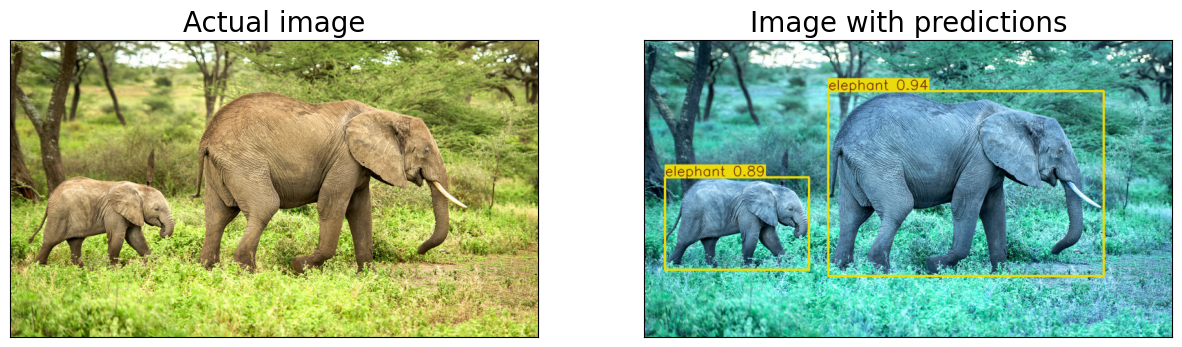

In [ ]:
# Specify the path to the image you want to predict
image_path = '/content/images/test/Tanz-Great-Migration0042_reduced.jpg'

# Load and display the original image
plt.figure(figsize=(15, 15))

# Display actual image
ax = plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB))
plt.xticks([])
plt.yticks([])
plt.title("Original image", fontsize=20)

# Predict using the model
res = model(image_path)

# Display the image with predictions
ax = plt.subplot(1, 2, 2)
res_plotted = res[0].plot()
plt.imshow(res_plotted)
plt.title("prediction", fontsize=20)
plt.xticks([])
plt.yticks([])

plt.show()


image 1/1 /content/images/test/zebra.jpg: 448x640 1 zebra, 146.2ms
Speed: 3.9ms preprocess, 146.2ms inference, 2.2ms postprocess per image at shape (1, 3, 448, 640)


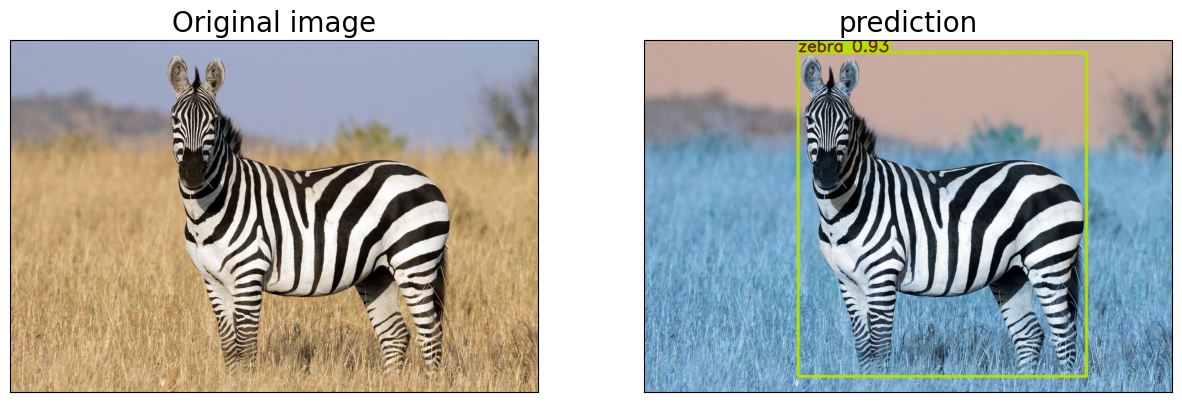

In [ ]:
# Specify the path to the image you want to predict
image_path = '/content/images/test/zebra.jpg'

# Load and display the original image
plt.figure(figsize=(15, 15))

# Display actual image
ax = plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB))
plt.xticks([])
plt.yticks([])
plt.title("Original image", fontsize=20)

# Predict using the model
res = model(image_path)

# Display the image with predictions
ax = plt.subplot(1, 2, 2)
res_plotted = res[0].plot()
plt.imshow(res_plotted)
plt.title("prediction", fontsize=20)
plt.xticks([])
plt.yticks([])

plt.show()

# Concluding remarks

Model's performance on a  test dataset is quite good as it is able to detect the name of the animal  present in the same image